In [1]:
def generate_points():
    n_samples = 100
    n_clusters = 3
    centers = [(-5, -5), (0, 0), (5, 5)]
    cluster_std = 0.5

    # Generate points for each cluster
    points = []
    labels = []

    for i, center in enumerate(centers):
        x = np.random.normal(center[0], cluster_std, n_samples // n_clusters)
        y = np.random.normal(center[1], cluster_std, n_samples // n_clusters)
        cluster_points = np.column_stack((x, y))
        points.append(cluster_points)
        labels.append(np.full(n_samples // n_clusters, i))

    points = np.vstack(points)
    labels = np.concatenate(labels)

    df = pd.DataFrame(points, columns=['Feature1', 'Feature2'])
    df['Label'] = labels
    df_sorted = df.sort_values(by=['Feature1', 'Feature2']).reset_index(drop=True)

    X = df_sorted[['Feature1', 'Feature2']].values
    GT = df_sorted['Label'].values

    # plt.scatter(X[:, 0], X[:, 1], c=GT, cmap='viridis')
    # plt.title('Generated and Sorted Points')
    # plt.xlabel('Feature1')
    # plt.ylabel('Feature2')
    # plt.show()

    return X, GT

GRID SIZE:  10
Data shape: (99, 2)
GT shape (99,)
(99,)
Initialized with NEigs = 40 (type: <class 'int'>)
Pairwise Distance Matrix:
[[ 0.          0.08271255  0.84401356 ... 14.96393996 15.6597332
  15.24477914]
 [ 0.08271255  0.          0.90991053 ... 14.88445965 15.57937403
  15.16564412]
 [ 0.84401356  0.90991053  0.         ... 15.46496032 16.18723713
  15.73565819]
 ...
 [14.96393996 14.88445965 15.46496032 ...  0.          0.9393221
   0.35783164]
 [15.6597332  15.57937403 16.18723713 ...  0.9393221   0.
   0.95821276]
 [15.24477914 15.16564412 15.73565819 ...  0.35783164  0.95821276
   0.        ]]
Transition Matrix:
[[0.         0.197711   0.         ... 0.         0.         0.        ]
 [0.1371869  0.         0.         ... 0.         0.         0.        ]
 [0.1522481  0.01539673 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.07842235]
 [0.         0.         0.         ... 0.02147854 0.         0.0124950

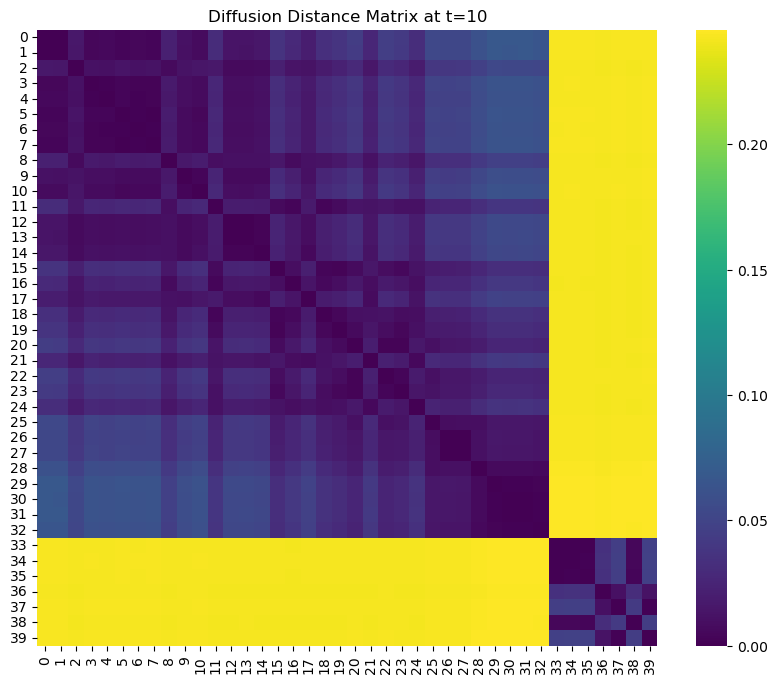

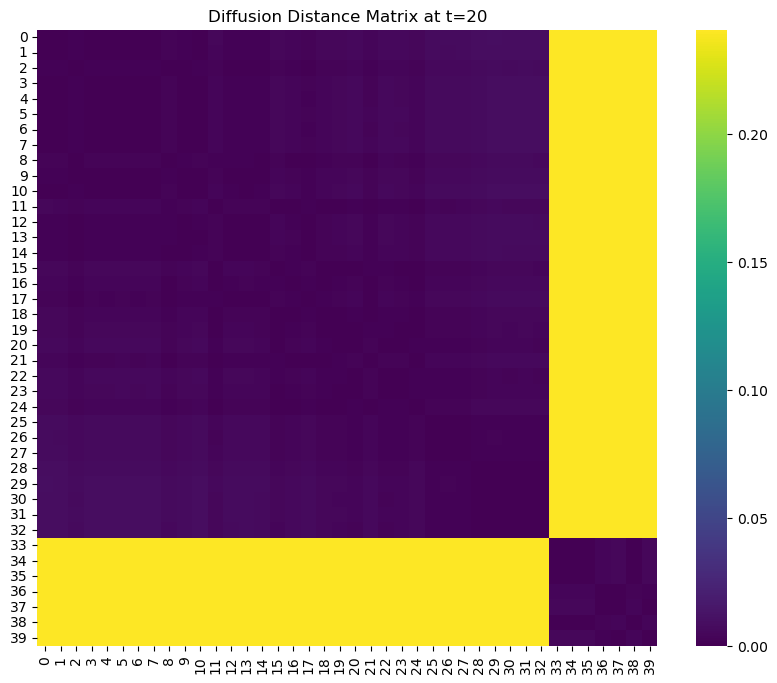

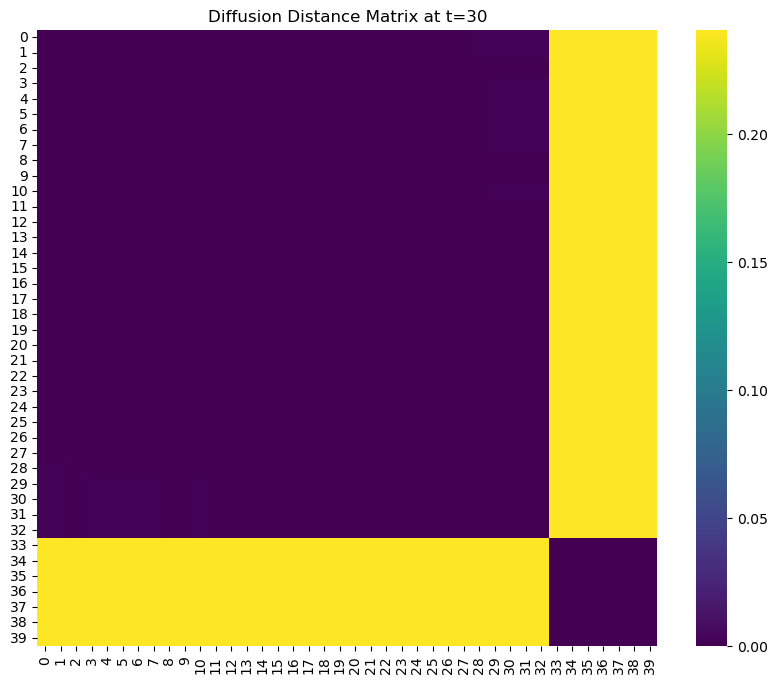

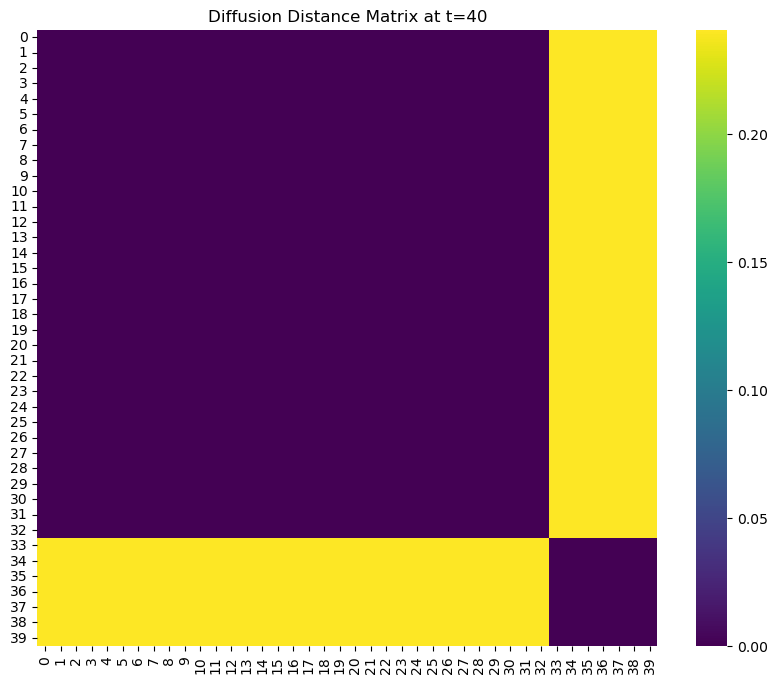

entered lund
Number of Eigenvalues: 40
Number of Eigenvectors: (40, 40)
40
Shape of G['EigenVecs']: (40, 40)
Shape of G['EigenVals']: (40,)
(99,)
(40, 40)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 40 but corresponding boolean dimension is 99

In [10]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification, make_circles
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

# data_path, gt_path, data_name, gt_name = '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_corrected.mat', '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt'


# X, M, N, D, HSI, GT, Y, n, K = loadHSI(data_path, gt_path, data_name, gt_name)
X,GT = generate_points()

scipy.io.savemat('data.mat', {'X': X, 'GT': GT})

grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)
print("GT shape", GT.shape)
# GT = GT - 1
# HSI = X.reshape((M, N, D))
# Hyperparameters = {
#     'Sigma': 1.0,
#     'DiffusionNN': 10,
    
# }

kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)
print(p.shape)
graph_extractor = GraphExtractor(sigma = 0.5, DiffusionNN = 10, NEigs = 40)
G = graph_extractor.extract_graph(X)


def plot_diffusion_distance(G, timestep):

    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at t={timestep}')
    plt.show()


for timestep in [10, 20, 30, 40]:
    plot_diffusion_distance(G, timestep)

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 30, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")


In [13]:
mat_data = scipy.io.loadmat('data/iris.mat')
print("Keys in the .mat file:", mat_data.keys())
X = mat_data['X']
GT = mat_data['GT']

# grid_size = int(np.ceil(np.sqrt(X.shape[0])))
# print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)
print("GT shape", GT.shape)
# GT = GT - 1
# HSI = X.reshape((M, N, D))
# Hyperparameters = {
#     'Sigma': 1.0,
#     'DiffusionNN': 10,
    
# }

kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)
print("pshape",p.shape)
graph_extractor = GraphExtractor(sigma = 0.5, DiffusionNN = 10,NEigs=100)
G = graph_extractor.extract_graph(X)


def plot_diffusion_distance(G, timestep):

    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at t={timestep}')
    plt.show()


# for timestep in [10, 20, 30, 40, 90]:
#     plot_diffusion_distance(G, timestep)

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 40, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

# accuracy = calculate_aligned_accuracy(GT, C)
# print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering)")
plot_clusters(X, GT, "Ground Truth")


Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'GT', 'X'])
Data shape: (150, 4)
GT shape (150, 1)
pshape (150,)
Initialized with NEigs = 100 (type: <class 'int'>)
Pairwise Distance Matrix:
[[0.         0.53851648 0.50990195 ... 4.45982062 4.65080638 4.14004831]
 [0.53851648 0.         0.3        ... 4.49888875 4.71805044 4.15331193]
 [0.50990195 0.3        0.         ... 4.66154481 4.84871117 4.29883705]
 ...
 [4.45982062 4.49888875 4.66154481 ... 0.         0.6164414  0.64031242]
 [4.65080638 4.71805044 4.84871117 ... 0.6164414  0.         0.76811457]
 [4.14004831 4.15331193 4.29883705 ... 0.64031242 0.76811457 0.        ]]
Transition Matrix:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.07966393 ... 0.         0.         0.        ]
 [0.         0.09081564 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.     

IndexError: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 150